### __Predicting Used Car Sale Prices__

--- 

**Overview:**   

In this project we will predict used car sale prices using historical data such as make, model, age and mileage. To do so, we will clean up the data by dealing with categorical features and missing observations, and creating new variables (feature engineering). With the resulting dataset, we will construct and tune a forecasting model, produce forecasts and submit the predictions to Kaggle.

---

## Problem Description and Initial Data Analysis


In [2]:
# Reading data into the notebook
import numpy as np 
import pandas as pd

train_data = pd.read_csv("data/train.csv")
# train_data.head()
test_data = pd.read_csv("data/test.csv")
# test_data.head()

### Forecasting Problem

The forecasting problem approached within this project is to predict the final sale price of used cars based on the characteristics of cars which have been previously sold. 

### Evaluation Criteria

The predicted model will be evaluated against a test dataset where sales price is known. The evaluation criteria used will be the Root Mean Square Error (RMSE) with our goal being to minimise RMSE. The Root Mean Square Error will measure the difference between the predicted sales price and the observed sales price by taking the square root of the second sample moment of the differences between these values. That is:

$$RMSE(\hat{price}) = \sqrt{E((\hat{price} - price)^2)}$$

### Types of Variables/Features

To get an initial view of the types of Features within the dataset we will use the following code:
```
train_data.info()
```

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   vin                   3500 non-null   object 
 1   back_legroom          3397 non-null   object 
 2   body_type             3494 non-null   object 
 3   city                  3500 non-null   object 
 4   city_fuel_economy     2912 non-null   float64
 5   daysonmarket          3500 non-null   int64  
 6   dealer_zip            3500 non-null   int64  
 7   engine_displacement   3375 non-null   float64
 8   engine_type           3450 non-null   object 
 9   exterior_color        3500 non-null   object 
 10  franchise_dealer      3500 non-null   bool   
 11  front_legroom         3397 non-null   object 
 12  fuel_tank_volume      3397 non-null   object 
 13  fuel_type             3463 non-null   object 
 14  height                3397 non-null   object 
 15  highway_fuel_economy 

We can see that the data *mostly* matches the "Description of Variables" from the kaggle competition page. The following differences are observed:
- The data contains a variable called `city_fuel_economy` which is not mentioned on the kaggle summary. We can assume that this is a similar measure to `highway_fuel_economy`, shown in km per litre but measured in city traffic. 
- The kaggle summary mentions a variable `has_accidents` which is not included in our dataset. 
- The dataset contains a variable called `model_name` which is not mentioned on the kaggle summary. This will be useful information when combined with the `make_name` as it can help to find missing values which relate to vehicle features (for example the width and length).

Price is stored as an integer but for the purpose of prediction it will be safe to treat this as a continuous numerical variable. We can see that many features have 3500 non-null values but there are some with missing values. The two fuel economy features both appear to contain the least amount of usable data.

There are a number of features stored as an **object** where we would expect to have numeric data. For example, `back_legroom`, `fuel_tank_volume` and `width` are features which represent numerical measurements.

### Data summary and main data characteristics

To get a general overview of the data we can use the following code:
```
train_data.describe()
train_data.nunique()
```

In [3]:
train_data.describe()

,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,highway_fuel_economy,horsepower,latitude,longitude,mileage,savings_amount,seller_rating,year,price
count,2912.000000,3500.000000,3500.000000,3375.000000,2912.000000,3375.000000,3500.000000,3500.000000,3297.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,21.655220,78.987714,11876.966857,2749.185185,28.658997,242.296889,40.549032,-74.212195,39277.213224,830.168286,3.934368,2017.015714,27133.806000
std,7.520448,104.838545,10893.589741,1115.578544,7.160677,87.287417,3.426925,2.947159,47300.958932,1318.130267,0.542599,4.037270,16502.784211
min,10.000000,0.000000,922.000000,1000.000000,13.000000,78.000000,18.398800,-84.346600,0.000000,0.000000,1.000000,1978.000000,899.000000
25%,18.000000,17.000000,7036.000000,2000.000000,25.000000,176.000000,40.745700,-74.075800,14.000000,0.000000,3.577778,2016.000000,15995.000000
50%,21.000000,39.500000,8812.000000,2400.000000,28.000000,240.000000,40.855800,-73.726800,25983.000000,206.000000,4.115385,2018.000000,25488.000000
75%,24.000000,82.000000,11706.000000,3500.000000,31.000000,292.000000,41.091200,-73.258700,57778.000000,1255.750000,4.375000,2020.000000,34012.500000
max,127.000000,698.000000,49203.000000,7000.000000,122.000000,797.000000,42.785100,-66.078500,329145.000000,12801.000000,5.000000,2021.000000,207900.000000


In [4]:
train_data.nunique()

vin                     3500
back_legroom             138
body_type                  9
city                      43
city_fuel_economy         44
daysonmarket             351
dealer_zip                46
engine_displacement       46
engine_type               20
exterior_color           738
franchise_dealer           2
front_legroom             75
fuel_tank_volume         116
fuel_type                  6
height                   252
highway_fuel_economy      46
horsepower               247
interior_color           379
is_new                     2
latitude                  49
length                   389
listed_date              351
listing_color             14
longitude                 49
make_name                 42
maximum_seating           10
mileage                 2241
model_name               398
power                    520
savings_amount          1466
seller_rating             44
torque                   510
transmission               4
transmission_display      23
wheel_system  

The description of the dataset provides a summary of data which is stored as numbers, but given the features identified above as being stored with an incorrect data type, it doesn't give us a full overview. We can see that `days_on_market` and `mileage` both have a minimum value of zero within the dataset, which might represent missing values but is worth further investigation. Other results from the description look to be as expected. Location data is available for all observations and the `latitude` and `longitude` values appear to make sense, generally representing coordinates for the Eastern states of USA. `seller_rating` looks to be an average of scores between 1 and 5. The maximum for `daysonmarket` looks like it could be an outlier (698 days) as well as `city_fuel_economy` at 127 km per litre, higher than the maximum `highway_fuel_economy` of 122 km per litre.

Looking at the number of unique values for each feature, we can see that each example has a unique `vin` as expected (although we could have potentially seen a single vehicle sold twice). There are some text-based features with a very high number of unique values, such as `interior_color` and `model_name`. These features are unlikely to be useful for prediction in their current form, but could potentially be transformed in our data cleaning steps.

### Missing Values

To look more closely at the features with missing values we will run this code:
```
train_data.isnull().sum(axis=0)
```

In [5]:
train_data.isnull().sum(axis=0)

vin                       0
back_legroom            103
body_type                 6
city                      0
city_fuel_economy       588
daysonmarket              0
dealer_zip                0
engine_displacement     125
engine_type              50
exterior_color            0
franchise_dealer          0
front_legroom           103
fuel_tank_volume        103
fuel_type                37
height                  103
highway_fuel_economy    588
horsepower              125
interior_color            0
is_new                    0
latitude                  0
length                  103
listed_date               0
listing_color             0
longitude                 0
make_name                 0
maximum_seating         103
mileage                 203
model_name                0
power                   299
savings_amount            0
seller_rating             0
torque                  331
transmission             60
transmission_display     60
wheel_system            101
wheelbase           

There are a number of features shown to have **103** missing values and they appear to relate to each other: `back_legroom`, `front_legroom`, `maximum_seating`, `wheelbase`, `length`, `width`, `height` and `fuel_tank_volume`. If we narrow this down further:

In [6]:
train_data[train_data.back_legroom.isnull()].isnull().sum(axis=0)

vin                       0
back_legroom            103
body_type                 6
city                      0
city_fuel_economy        90
daysonmarket              0
dealer_zip                0
engine_displacement      97
engine_type              28
exterior_color            0
franchise_dealer          0
front_legroom           103
fuel_tank_volume        103
fuel_type                15
height                  103
highway_fuel_economy     90
horsepower               97
interior_color            0
is_new                    0
latitude                  0
length                  103
listed_date               0
listing_color             0
longitude                 0
make_name                 0
maximum_seating         103
mileage                   1
model_name                0
power                    98
savings_amount            0
seller_rating             0
torque                   98
transmission              3
transmission_display      3
wheel_system             80
wheelbase           

We see that it is the same subset of examples which are missing all of these measurement-related features. To investigate how many records have multiple features missing, we use the following code:

In [67]:
null_rows = train_data.isnull().sum(axis=1).sort_values(ascending=False)

count = (len(null_rows[null_rows == 17].index))
print(f'17 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 16].index))
print(f'16 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 15].index))
print(f'15 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 14].index))
print(f'14 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 13].index))
print(f'13 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 12].index))
print(f'12 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 11].index))
print(f'11 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows == 10].index))
print(f'10 null values: {count} entries {count/3500*100:.2f}%')

count = (len(null_rows[null_rows >= 15].index))
print(f'----\n15 or more null values: {count} entries {count/3500*100:.2f}%')

17 null values: 16 entries 0.46%
16 null values: 7 entries 0.20%
15 null values: 63 entries 1.80%
14 null values: 1 entries 0.03%
13 null values: 7 entries 0.20%
12 null values: 5 entries 0.14%
11 null values: 0 entries 0.00%
10 null values: 2 entries 0.06%
----
15 or more null values: 86 entries 2.46%


#### Visualising Missing Values

Visualising missing values can often help us figure out if there is a correlation between missing features. In our data we can see that where highway fuel economy is missing, city fuel economy is also missing 100% of the time.

<AxesSubplot:>

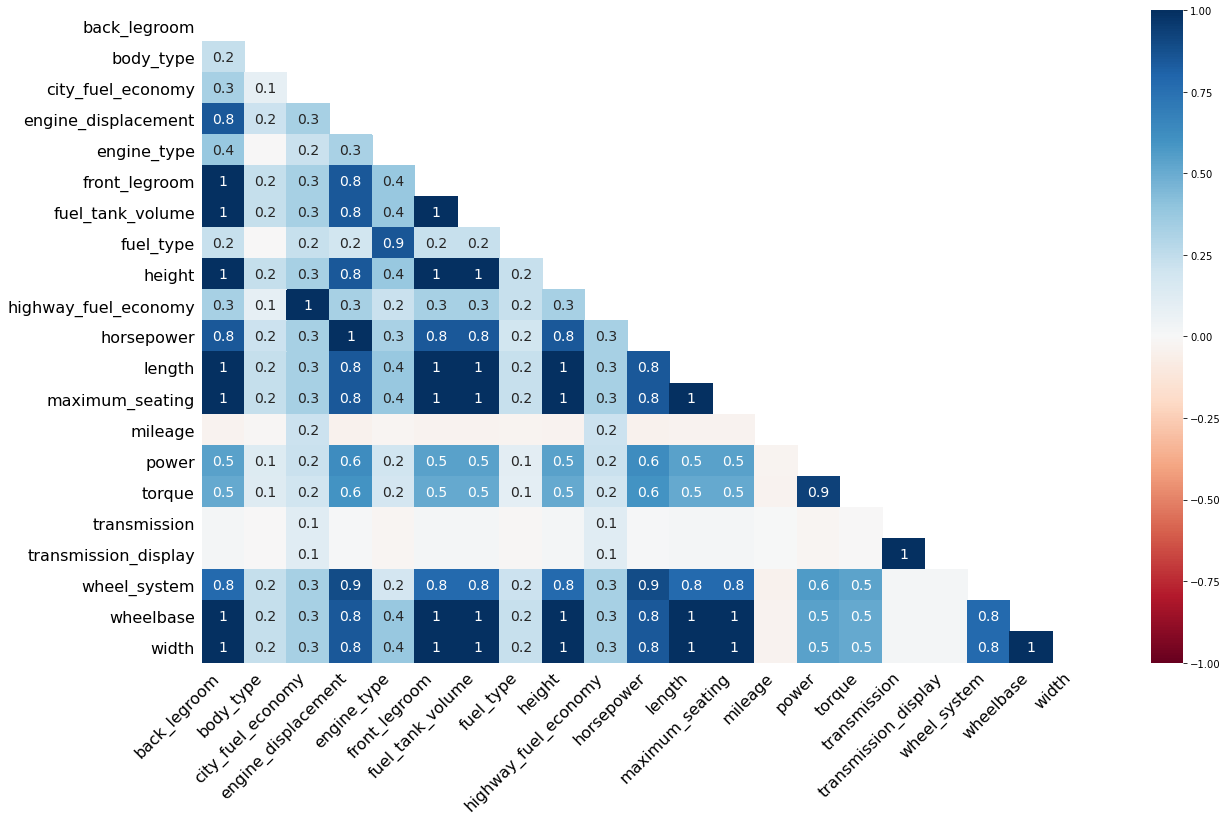

In [6]:
import missingno as msno

msno.heatmap(train_data)

This chart shows us that features that there is definitely some correlation between missing features. The dimensional data of each car, i.e. legroom, width, length, height, wheelbase, and number of seats are all missing together for the same entries.

<AxesSubplot:>

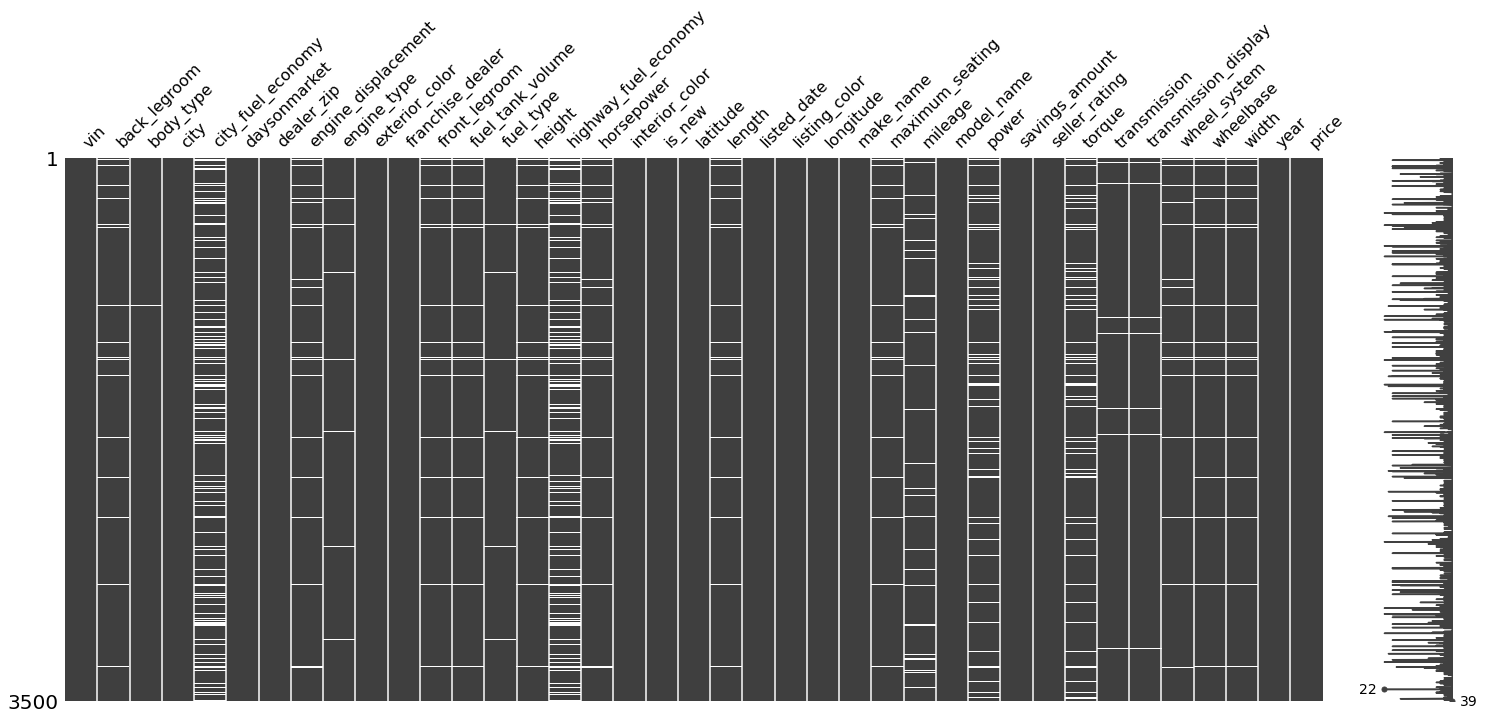

In [7]:
msno.matrix(train_data)

The above plot highlights how influential missing values will be for `city_fuel_economy` and `highway_fuel_economy`. Since we have no missing values in the `make_name` and `model_name` features we can likely use these when imputing the missing values.

---

## Data Cleaning, Missing Observations and Feature Engineering

In [8]:
# We are going to work with a copy of the dataframe in Task 2
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.width", None)
df = train_data.copy() # assign a copy of the training data to 'df'
df_test = test_data.copy() # to save coding time, we will process cleaning steps of the test dataset at the same time using 'df_test'

The following variables are measured in inches and thus have 'in' added at the end as the unit, preventing us from using these variables as numbers.
- back_legroom
- front_legroom
- height
- length
- wheelbase
- width

This code uses a loop to remove it. The second line removes 'in' from the end. The third line changes the data type of the column to numeric where all non-numeric entries are changed to null. So, '--' is changed to null.

In [9]:
for col in df[['back_legroom','front_legroom','height','length','wheelbase','width']]:
    df[col] = df[col].str.rstrip(' in')
    df[col] = df[col].apply(pd.to_numeric, errors='coerce')

# -- Test Dataset --
for col in df_test[['back_legroom','front_legroom','height','length','wheelbase','width']]:
    df_test[col] = df_test[col].str.rstrip(' in')
    df_test[col] = df_test[col].apply(pd.to_numeric, errors='coerce')

The fuel_tank_volume variable is measured in gallons and has 'gal' added to the end. The process is the same as before.

In [10]:
df['fuel_tank_volume'] = df['fuel_tank_volume'].str.rstrip(' gal')                         #removes 'gal' from each field
df['fuel_tank_volume'] = df['fuel_tank_volume'].apply(pd.to_numeric, errors='coerce')      #convert column to float dtype and anything that isn't float converted to null
df['fuel_tank_volume'] = df['fuel_tank_volume'].replace(0.0, np.NaN)                       #convert 0 values to null

# -- Test Dataset --
df_test['fuel_tank_volume'] = df_test['fuel_tank_volume'].str.rstrip(' gal')                         #removes 'gal' from each field
df_test['fuel_tank_volume'] = df_test['fuel_tank_volume'].apply(pd.to_numeric, errors='coerce')      #convert column to float dtype and anything that isn't float converted to null
df_test['fuel_tank_volume'] = df_test['fuel_tank_volume'].replace(0.0, np.NaN)                       #convert 0 values to null

We do the same thing for maximum_seating. This time we remove 'seats' from the end.

In [11]:
df['maximum_seating'] = df['maximum_seating'].str.rstrip(' seats')
df['maximum_seating'] = df['maximum_seating'].apply(pd.to_numeric, errors='coerce')

# -- Test Dataset --
df_test['maximum_seating'] = df_test['maximum_seating'].str.rstrip(' seats')
df_test['maximum_seating'] = df_test['maximum_seating'].apply(pd.to_numeric, errors='coerce')

---

Here we separate the number of gears and the transmission type from 'transmission_display'. The transmission type is already included in the 'transmission' feature. So, for the 'transmission_display' feature we are only interested in the maximum number of gears. The number of gears is given in the first character so we extract the first character in line 1 of the code and update 'transmission_display'. Now we have a mix of numbers and letters in this column. The numbers represent the gears and the letters exist only in places where the number of gears are not given. The letter C denotes CVT which is technically a single gear transmission. So, in line 2 of the code, we replace C with 1. Then in line 3 we change the column type to numeric and all non-numeric values are changed to null. Finally, in line 4 we rename the column to 'maximum_gears'.

In [69]:
train_data[['transmission_display','power','torque']].head(1)

,transmission_display,power,torque
0,7-Speed Automatic,"208 hp @ 5,500 RPM","258 lb-ft @ 1,200 RPM"


In [12]:
df.transmission_display = df.transmission_display.str[0]                                          # get first digit from each entry
df.transmission_display.replace('C', 1, inplace=True)                                             # change CVT to 1 gear
df['transmission_display'] = df['transmission_display'].apply(pd.to_numeric, errors='coerce')     # change dtype to numeric
df.rename(columns = {'transmission_display':'maximum_gears'}, inplace = True)                     # replace column name to maximum_gears

# -- Test Dataset --
df_test.transmission_display = df_test.transmission_display.str[0]                                     # get first digit from each entry
df_test.transmission_display.replace('C', 1, inplace=True)                                             # change CVT to 1 gear
df_test['transmission_display'] = df_test['transmission_display'].apply(pd.to_numeric, errors='coerce')# change dtype to numeric
df_test.rename(columns = {'transmission_display':'maximum_gears'}, inplace = True)                     # replace column name to maximum_gears

The 'power' feature contains the horsepower and the RPM at which the power is produced. There is already a 'horsepower' feature for each entry so from the 'power' feature we are only interested in the RPM. The first line of the code splits the string around the '@' character and the RPM is stored in a new variable. Then the new variable is used to replace the values in the 'power' feature in our main dataframe. In the third line of the code we clean up the entries by removing 'RPM' from the end, removing all extra spaces and the comma. Then we change the data type to numeric and rename the column from 'power' to 'power_RPM'.

In [13]:
hp_rpm = df.power.str.split("@", expand=True)[1]
df['power'] = hp_rpm.values
df.power = df.power.str.rstrip(' RPM').str.strip().str.replace(",","")
df['power'] = df['power'].apply(pd.to_numeric, errors='coerce')
df.rename(columns = {'power':'power_RPM'}, inplace = True)

# -- Test Dataset --
hp_rpm = df_test.power.str.split("@", expand=True)[1]
df_test['power'] = hp_rpm.values
df_test.power = df_test.power.str.rstrip(' RPM').str.strip().str.replace(",","")
df_test['power'] = df_test['power'].apply(pd.to_numeric, errors='coerce')
df_test.rename(columns = {'power':'power_RPM'}, inplace = True)

The 'torque' column is similar to the power column as it contains both the torque value and the RPM at which the torque is produced. Here we need to split these two information into two features. The first step is to split the string around the '@' character. This gives us a new dataframe with two columns. The first column contains the torque value measured in 'lb-ft' and the second contains the RPM. Line 2 of the code cleans up the torque values by removing the unit and any whitespace. The third line does the same with the RPM values. The fourth line replaces all the old torque values with the new torque values that we cleaned up. The fifth line inserts a new column at index 33 called 'torque_RPM' which contains the RPM values that we split and cleaned previously. The last step changes the two new variables to numeric data type.

In [14]:
torque_RPM = df.torque.str.split("@", expand=True)
torque_RPM[0] = torque_RPM[0].str.rstrip(' lb-ft').str.strip()
torque_RPM[1] = torque_RPM[1].str.rstrip(' RPM').str.strip().str.replace(",","")
df.torque = torque_RPM[0].values
df.insert(33, 'torque_RPM', torque_RPM[1])

for col in df[['torque','torque_RPM']]:
     df[col] = df[col].apply(pd.to_numeric, errors='coerce')

# -- Test Dataset --
torque_RPM = df_test.torque.str.split("@", expand=True)
torque_RPM[0] = torque_RPM[0].str.rstrip(' lb-ft').str.strip()
torque_RPM[1] = torque_RPM[1].str.rstrip(' RPM').str.strip().str.replace(",","")
df_test.torque = torque_RPM[0].values
df_test.insert(33, 'torque_RPM', torque_RPM[1])

for col in df_test[['torque','torque_RPM']]:
     df_test[col] = df_test[col].apply(pd.to_numeric, errors='coerce')

---

The following code imputes missing variable in all columns. In general, we have mostly filled missing data using summaries filtered on other features. For example, in the first group of features imputed below the median value grouped by the Make and Model of the car is used to fill missing values.

We grouped the data based on `make_name` and `model_name` and imputed the missing values for these numerical features based on the existing entries with the same make and model. The median value for each make and model was used to impute missing data.

In [15]:
# Imputes all numerical variables based on make and model. This step gets rid of a lot of null values but many still remain which needs
# to be processed further.
for col in df[['back_legroom','highway_fuel_economy','city_fuel_economy','maximum_seating','maximum_gears','engine_displacement','front_legroom','fuel_tank_volume','height','length','horsepower','power_RPM','torque','torque_RPM','wheelbase','width']]:
    median = df.groupby(['make_name', 'model_name'])[col].agg(pd.Series.median)
    df[col] = df.apply(lambda x: median[x.make_name, x.model_name] if pd.isnull(x[col]) else x[col], axis=1)
    # -- Test Dataset --
    colname = df[col].name
    df_test[colname] = df_test.apply(lambda x: median[x.make_name, x.model_name] if (pd.isnull(x[colname]) and median.index.isin([(x.make_name, x.model_name)]).any()) else x[colname], axis=1)  # need to check if the make and model match our values from training

We imputed the missing `transmission` values based on the existing entries with the same make and model. The modal value for each make and model was used. 

In [16]:
# IMPUTES VALUES FOR transmission
modes = df.groupby(['make_name', 'model_name']).transmission.agg(pd.Series.mode)
df.transmission = df.apply(lambda x: str(modes[x.make_name, x.model_name]) if pd.isnull(x.transmission) else x.transmission, axis=1)

# -- Test Dataset --
df_test.transmission = df_test.apply(lambda x: str(modes[x.make_name, x.model_name]) if (pd.isnull(x.transmission) and modes.index.isin([(x.make_name, x.model_name)]).any()) else x.transmission, axis=1)

We imputed the missing `body_type` values based on the existing entries with the same make and model. The modal value for each make and model was used. This did not fill all missing values for body_type, so a second step repeats the process using a less-specific description for `model_name`.

In [17]:
# IMPUTES ALL BODY_TYPE

modes = df.groupby(['make_name', 'model_name']).body_type.agg(pd.Series.mode)
# creates a multi-index object with the most frequent 'body_type' for each 'make_name'/'model_name' combination

df.body_type = df.apply(lambda x: str(modes[x.make_name][x.model_name]) if pd.isnull(x.body_type) else x.body_type, axis=1)
# if 'body_type' is null, replace value with the matching body_type from "modes" object, otherwise leave it as is

# -- Test Dataset --
df.body_type = df.apply(lambda x: str(modes[x.make_name][x.model_name]) if (pd.isnull(x.body_type) and modes.index.isin([(x.make_name, x.model_name)]).any()) else x.body_type, axis=1)
# ------------------

# to catch remaining missing values, expand the scope of models to just the first word (e.g. strip out 'Hybrid' or other class names)
new_df = df[['make_name','model_name','body_type']].copy()
new_df['model_name'] = new_df['model_name'].str.partition()[0]
modes2 = new_df.groupby(['make_name', 'model_name']).body_type.agg(pd.Series.mode)
new_df['body_type'] = new_df['body_type'].replace("[]",np.NaN)
new_df.body_type = new_df.apply(lambda x: str(modes2[x.make_name][x.model_name]) if pd.isnull(x.body_type) else x.body_type, axis=1)
df['body_type'] = new_df['body_type']

# -- Test Dataset --
new_df = df_test[['make_name','model_name','body_type']].copy()
new_df['model_name'] = new_df['model_name'].str.partition()[0]
new_df['body_type'] = new_df['body_type'].replace("[]",np.NaN)
new_df.body_type = new_df.apply(lambda x: str(modes2[x.make_name][x.model_name]) if (pd.isnull(x.body_type) and modes2.index.isin([(x.make_name, x.model_name)]).any()) else x.body_type, axis=1)
df_test['body_type'] = new_df['body_type']

We imputed the missing `fuel_type` values based on the existing entries with the same make and model. The modal value for each make and model was used.

In [18]:
# IMPUTES fuel_type
# fills in missing values based on make and model. Any remaining missing values get assigned to 'Other' type.
modes = df.groupby(['make_name', 'model_name']).fuel_type.agg(pd.Series.mode)
df.fuel_type = df.apply(lambda x: str(modes[x.make_name, x.model_name]) if pd.isnull(x.fuel_type) else x.fuel_type, axis=1)
df['fuel_type'] = df['fuel_type'].replace('[]', 'Other')
df['fuel_type'] = df['fuel_type'].replace('Biodiesel', 'Other')

# -- Test Dataset --
df_test.fuel_type = df_test.apply(lambda x: str(modes[x.make_name, x.model_name]) if (pd.isnull(x.fuel_type) and modes.index.isin([(x.make_name, x.model_name)]).any()) else x.fuel_type, axis=1)
df_test['fuel_type'] = df_test['fuel_type'].replace('[]', 'Other')
df_test['fuel_type'] = df_test['fuel_type'].replace('Biodiesel', 'Other')

We imputed the missing `wheel_system` values based on the existing entries with the same make and model. The modal value for each make and model was used. This did not fill all missing values, so a second step repeats the process based on existing entries with the same `body_type`.

In [19]:
# IMPUTES wheel_system
# The first step matches value with make and model
modes = df.groupby(['make_name', 'model_name']).wheel_system.agg(pd.Series.mode)
df.wheel_system = df.apply(lambda x: str(modes[x.make_name, x.model_name]) if pd.isnull(x.wheel_system) else x.wheel_system, axis=1)
df['wheel_system'] = df['wheel_system'].replace('[]', np.NaN)

# Some null values remain; these are imputed in 2nd step from body_type
mode = df.groupby(['body_type']).wheel_system.agg(pd.Series.mode)
df.wheel_system = df.apply(lambda x: mode[x.body_type] if pd.isnull(x.wheel_system) else x.wheel_system, axis=1)

# -- Test Dataset --
df_test.wheel_system = df_test.apply(lambda x: str(modes[x.make_name, x.model_name]) if (pd.isnull(x.wheel_system) and modes.index.isin([(x.make_name, x.model_name)]).any()) else x.wheel_system, axis=1)
df_test['wheel_system'] = df_test['wheel_system'].replace('[]', np.NaN)
df_test.wheel_system = df_test.apply(lambda x: mode[x.body_type] if (pd.isnull(x.wheel_system) and (x.body_type in mode.index)) else x.wheel_system, axis=1)

There were some values still missing for `maximum_seating` so we have imputed these based on the existing entries with the same `body_type`. 

In [20]:
# where maximum_seating is still missing, use mode from other vehicles with same body_type
modes = df.groupby('body_type').maximum_seating.agg(pd.Series.mode)
df.maximum_seating = df.apply(lambda x: modes[x.body_type] if pd.isnull(x.maximum_seating) else x.maximum_seating, axis=1)

# -- Test Dataset --
df_test.maximum_seating = df_test.apply(lambda x: modes[x.body_type] if (pd.isnull(x.maximum_seating) and (x.body_type in modes.index)) else x.maximum_seating, axis=1)

There were some values still missing for `back_legroom` and `front_legroom` so we have imputed these based on a combination of `make_name` and `body_type` features.

In [21]:
# back_legroom is zero when max seating = 2
df.back_legroom = df.apply(lambda x: 0 if (pd.isnull(x.back_legroom) and x.maximum_seating==2) else x.back_legroom, axis=1)

# -- Test Dataset --
df_test.back_legroom = df_test.apply(lambda x: 0 if (pd.isnull(x.back_legroom) and x.maximum_seating==2) else x.back_legroom, axis=1)
# ------------------

# any other missing back_legroom & front_legroom values can be filled based on body_type and make_name
for col in df[['back_legroom', 'front_legroom']]:
    means_1 = df.groupby(['make_name', 'body_type'])[col].mean()
    df[col] = df.apply(lambda x: means_1[x.make_name, x.body_type] if pd.isnull(x[col]) else x[col], axis=1)
    means_2 = df.groupby(['body_type'])[col].mean()
    df[col] = df.apply(lambda x: means_2[x.body_type] if pd.isnull(x[col]) else x[col], axis=1)
    # -- Test Dataset --
    colname = df[col].name
    df_test[colname] = df_test.apply(lambda x: means_1[x.make_name, x.body_type] if (pd.isnull(x[colname]) and means_1.index.isin([(x.make_name, x.body_type)]).any()) else x[colname], axis=1)
    df_test[colname] = df_test.apply(lambda x: means_2[x.body_type] if (pd.isnull(x[colname]) and (x.body_type in means_2.index)) else x[colname], axis=1)

Where `length`, `width`, `height`, `wheelbase` and `fuel_tank_volume` are still missing, use average from other vehicles with same make_name and "simplified" `model_name`.
Any other missing values can be filled based on `body_type`.

In [22]:
# where length, width, height, wheelbase and fuel_tank_volume are still missing, use average from other vehicles with same make_name and "simplified" model_name
# any other missing values can be filled based on body_type
new_df = df[['make_name','model_name','length','width','height','wheelbase','fuel_tank_volume','body_type']].copy()
new_df['model_name'] = new_df['model_name'].str.partition()[0]

# -- Test Dataset --
new_df_test = df_test[['make_name','model_name','length','width','height','wheelbase','fuel_tank_volume','body_type']].copy()
new_df_test['model_name'] = new_df_test['model_name'].str.partition()[0]
# ------------------

for col in new_df[['length', 'width', 'height', 'wheelbase', 'fuel_tank_volume']]:
    means = new_df.groupby(['make_name', 'model_name'])[col].mean()
    new_df[col] = new_df.apply(lambda x: means[x.make_name][x.model_name] if pd.isnull(x[col]) else x[col], axis=1)
    means2 = new_df.groupby(['body_type'])[col].mean()
    new_df[col] = new_df.apply(lambda x: means2[x.body_type] if pd.isnull(x[col]) else x[col], axis=1)
    df[col] = new_df[col]
    # -- Test Dataset --
    colname = new_df[col].name
    new_df_test[colname] = new_df_test.apply(lambda x: means[x.make_name][x.model_name] if (pd.isnull(x[colname]) and means.index.isin([(x.make_name, x.model_name)]).any()) else x[colname], axis=1)
    new_df_test[colname] = new_df_test.apply(lambda x: means2[x.body_type] if (pd.isnull(x[colname]) and (x.body_type in means2.index)) else x[colname], axis=1)
    df_test[colname] = new_df_test[colname]

We imputed missing `fuel_type` for Electric vehicles (as this was missing for all Electric `engine_type` vehicles) to a new value of "Electric". The same approach was taken to set `engine_displacement` to 0 and `maximum_gears` to 1.

In [23]:
# ELECTRIC VEHICLES
# Change all electric vehicle engine displacement to 0 and number of gears to 1.
df.loc[df['fuel_type'] == 'Electric', 'engine_type'] = 'Electric'
df.loc[df['fuel_type'] == 'Electric', 'engine_displacement'] = 0
df.loc[df['fuel_type'] == 'Electric', 'maximum_gears'] = 1

# -- Test Dataset --
df_test.loc[df_test['fuel_type'] == 'Electric', 'engine_type'] = 'Electric'
df_test.loc[df_test['fuel_type'] == 'Electric', 'engine_displacement'] = 0
df_test.loc[df_test['fuel_type'] == 'Electric', 'maximum_gears'] = 1

We simplified the data within `engine_type` to remove information which is already noted in other features (such as "Hybrid") and then imputed missing values based on the modal value of other vehicles with a matching `body_type`.

In [24]:
# ENGINE TYPE
# First remove all extra string like 'hybrid' and only keep the configuration like 'I4'
df['engine_type'] = df['engine_type'].str.partition()[0]

# imputed from body_type in 2nd step
modes = df.groupby('body_type').engine_type.agg(pd.Series.mode)
df.engine_type = df.apply(lambda x: str(modes[x.body_type]) if pd.isnull(x.engine_type) else x.engine_type, axis=1)

# -- Test Dataset --
df_test['engine_type'] = df_test['engine_type'].str.partition()[0]
df_test.engine_type = df_test.apply(lambda x: str(modes[x.body_type]) if (pd.isnull(x.engine_type) and (x.body_type in modes.index)) else x.engine_type, axis=1)

We imputed the missing `engine_displacement` values based on the existing entries with the same `body_type` and `engine_type`. The median value for each make and model was used.

In [25]:
# ENGINE DISPLACEMENT

median = df.groupby(['body_type', 'engine_type']).engine_displacement.agg(pd.Series.median)
df.engine_displacement = df.apply(lambda x: median[x.body_type, x.engine_type] if pd.isnull(x.engine_displacement) else x.engine_displacement, axis=1)

# -- Test Dataset --
df_test.engine_displacement = df_test.apply(lambda x: median[x.body_type, x.engine_type] if (pd.isnull(x.engine_displacement) and median.index.isin([(x.body_type, x.engine_type)]).any()) else x.engine_displacement, axis=1)

Where `city_fuel_economy` and `highway_fuel_economy` are still missing, we used the median from other vehicles with same `engine_type` and `fuel_type`. There were still some missing values, so the process was repeated based on matching `engine_type` and `body_type`.

In [26]:
# where city_fuel_economy and highway_fuel_economy are still missing, use average from other vehicles with same engine_type and fuel_type
for col in df[['city_fuel_economy','highway_fuel_economy']]:
    median = df.groupby(['engine_type', 'fuel_type'])[col].median()
    df[col] = df.apply(lambda x: median[x.engine_type, x.fuel_type] if pd.isnull(x[col]) else x[col], axis=1)
    # -- Test Dataset --
    colname = df[col].name
    df_test[colname] = df_test.apply(lambda x: median[x.engine_type, x.fuel_type] if (pd.isnull(x[colname]) and median.index.isin([(x.engine_type, x.fuel_type)]).any()) else x[colname], axis=1)
    
# do a second run with engine_type and body_type since some null values still remain
for col in df[['city_fuel_economy','highway_fuel_economy']]:
    median = df.groupby(['engine_type', 'body_type'])[col].median()
    df[col] = df.apply(lambda x: median[x.engine_type, x.body_type] if pd.isnull(x[col]) else x[col], axis=1)
    # -- Test Dataset --
    colname = df[col].name
    df_test[colname] = df_test.apply(lambda x: median[x.engine_type, x.body_type] if (pd.isnull(x[colname]) and median.index.isin([(x.engine_type, x.body_type)]).any()) else x[colname], axis=1)

We imputed the missing `horesepower` values based on the mean value for existing entries with the same `engine_displacement` and `engine_type`. There were still some missing values, so the process was repeated based on matching `body_type`.

In [27]:
#HORSEPOWER
# needs to be done in two steps because some null values still remain
mean = df.groupby(['engine_type', 'engine_displacement']).horsepower.agg(pd.Series.mean)
df.horsepower = df.apply(lambda x: mean[x.engine_type, x.engine_displacement] if pd.isnull(x.horsepower) else x.horsepower, axis=1)

# -- Test Dataset --
df_test.horsepower = df_test.apply(lambda x: mean[x.engine_type, x.engine_displacement] if (pd.isnull(x.horsepower) and mean.index.isin([(x.engine_type, x.engine_displacement)]).any()) else x.horsepower, axis=1)
# ------------------

# step 2
mean = df.groupby(['body_type']).horsepower.agg(pd.Series.mean)
df.horsepower = df.apply(lambda x: mean[x.body_type] if pd.isnull(x.horsepower) else x.horsepower, axis=1)

# -- Test Dataset --
df_test.horsepower = df_test.apply(lambda x: mean[x.body_type] if (pd.isnull(x.horsepower) and (x.body_type in mean.index)) else x.horsepower, axis=1)

We imputed the missing `torque` values based on the mean value for existing entries with the same `engine_displacement` and `engine_type`. There were still some missing values, so the process was repeated based on matching `body_type`.

In [28]:
# TORQUE
# Same as horsepower. First impute based on engine type and displacement, second impute based on body type
mean = df.groupby(['engine_type', 'engine_displacement']).torque.agg(pd.Series.mean)
df.torque = df.apply(lambda x: mean[x.engine_type, x.engine_displacement] if pd.isnull(x.torque) else x.torque, axis=1)

# -- Test Dataset --
df_test.torque = df_test.apply(lambda x: mean[x.engine_type, x.engine_displacement] if (pd.isnull(x.torque) and mean.index.isin([(x.engine_type, x.engine_displacement)]).any()) else x.torque, axis=1)
# ------------------

mean = df.groupby(['body_type']).torque.agg(pd.Series.mean)
df.torque = df.apply(lambda x: mean[x.body_type] if pd.isnull(x.torque) else x.torque, axis=1)

# -- Test Dataset --
df_test.torque = df_test.apply(lambda x: mean[x.body_type] if (pd.isnull(x.torque) and (x.body_type in mean.index)) else x.torque, axis=1)

We imputed the missing `torque_RPM` and `power_RPM` values based on the mean value for existing entries with the same `engine_displacement` and `engine_type`. There were still some missing values, so the process was repeated based on matching `body_type`.

In [29]:
# TORQUE AND HORSEPOWER RPM
# both done in one go using a loop. Method is same as horsepower and torque
for col in df[['power_RPM','torque_RPM']]:
    mean = df.groupby(['engine_type', 'engine_displacement'])[col].agg(pd.Series.mean)
    df[col] = df.apply(lambda x: mean[x.engine_type, x.engine_displacement] if pd.isnull(x[col]) else x[col], axis=1)
    
    mean_b = df.groupby(['body_type'])[col].agg(pd.Series.mean)
    df[col] = df.apply(lambda x: mean_b[x.body_type] if pd.isnull(x[col]) else x[col], axis=1)
    # -- Test Dataset --
    colname = df[col].name
    df_test[colname] = df_test.apply(lambda x: mean[x.engine_type, x.engine_displacement] if (pd.isnull(x[colname]) and mean.index.isin([(x.engine_type, x.engine_displacement)]).any()) else x[colname], axis=1)
    df_test[colname] = df_test.apply(lambda x: mean_b[x.body_type] if (pd.isnull(x[colname]) and (x.body_type in mean_b.index)) else x[colname], axis=1)

We imputed the missing `mileage` values based on the mean value for existing entries with the same `year`.

In [30]:
# MILEAGE
# mileage is imputed by taking the average mileage of all cars from the respective year
mean = df.groupby(['year']).mileage.agg(pd.Series.mean)
df.mileage = df.apply(lambda x: mean[x.year] if pd.isnull(x.mileage) else x.mileage, axis=1)

# -- Test Dataset --
df_test.mileage = df_test.apply(lambda x: mean[x.year] if (pd.isnull(x.mileage) and (x.year in mean.index)) else x.mileage, axis=1)

We imputed the missing `maximum_gears` values based on the median value for existing entries with the same `transmission`, `engine_type` and `Body_type`. There were still some missing values, so the process was repeated based on matching `body_type`.

In [31]:
# NUMBER OF GEARS
# where number of gears is still missing, we impute the values from transmission type, engine type, and body type.
median = df.groupby(['transmission','engine_type', 'body_type']).maximum_gears.agg(pd.Series.median)
df.maximum_gears = df.apply(lambda x: median[x.transmission, x.engine_type, x.body_type] if pd.isnull(x.maximum_gears) else x.maximum_gears, axis=1)

# some null values still remain, so we need a second step
mode = df.groupby(['body_type']).maximum_gears.agg(pd.Series.mode)
df.maximum_gears = df.apply(lambda x: mode[x.body_type] if pd.isnull(x.maximum_gears) else x.maximum_gears, axis=1)

# -- Test Dataset --
df_test.maximum_gears = df_test.apply(lambda x: median[x.transmission, x.engine_type, x.body_type] if (pd.isnull(x.maximum_gears) and median.index.isin([(x.transmission, x.engine_type, x.body_type)]).any()) else x.maximum_gears, axis=1)
df_test.maximum_gears = df_test.apply(lambda x: mode[x.body_type] if (pd.isnull(x.maximum_gears) and (x.body_type in mode.index)) else x.maximum_gears, axis=1)

As a final step on the Test Dataset, we have used the Pandas **fillna** method to catch any remaining missing values.

In [32]:
# as a final step on the Test Dataset, use a Pandas 'fillna' to catch anything that was missed
df_test = df_test.fillna(df_test.agg(lambda x: pd.Series.mode(x)[0], axis=0))

### Encoding Categorical Features

**(A) Listing Color:** The first categorical feature to be encoded is the `listing_color`. This shows the same information as the `exterior_color` feature, but in a more simple format.

In [34]:
# Create a new data frame with the 'listing_color' and 'exterior_color' features
new_df = df[['listing_color', 'exterior_color']].copy()
# new_df.head()

# find the number of unique values in the 'listing_color' column
unique_categories = len(new_df['listing_color'].unique())
# print('Unique values:', unique_categories)

# find the top 5 colors
new_df.listing_color.value_counts().sort_values(ascending=False).head(5)

# -- Test Dataset --
new_df_test = df_test[['listing_color', 'exterior_color']].copy()

We found that the 5th most common listing_color is "UNKNOWN" so for all rows which have a `listing_color` of "UNKNOWN" and an `exterior_color` that contains one of the existing `listing_color` values, we replace "UNKNOWN" with the matching known color name.

In [35]:
# 1. create list of unique values in 'listing_color' but omit "UNKNOWN"
all_colors = [x for x in new_df.listing_color.value_counts().sort_values(ascending=False).index]
all_colors.remove('UNKNOWN')

# 2. for each known color in the list, when the 'exterior_color' contains the sub-string of the color name, then replace "UNKNOWN" with the known color name
for x in all_colors:
    new_df.loc[(new_df['exterior_color'].str.contains(x, case=False)) & (new_df['listing_color']=='UNKNOWN'), 'listing_color'] = x
    # -- Test Dataset --
    new_df_test.loc[(new_df_test['exterior_color'].str.contains(x, case=False)) & (new_df_test['listing_color']=='UNKNOWN'), 'listing_color'] = x

We can now find the top 5 color categories again.

In [36]:
new_df.listing_color.value_counts().sort_values(ascending=False).head(5)
# the training data set shows that the top 5 colors are: BLACK, WHITE, GRAY, SILVER, BLUE 
# we will store the top 5 colors in a list
top_5 = [x for x in new_df.listing_color.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# we can now create an "OTHER" category for colors which are not in the top 5
new_df.loc[~new_df['listing_color'].isin(top_5),'listing_color'] = "OTHER"
# new_df.head(20)

# encode listing_color using get_dummies
one_hot_listing_color = pd.get_dummies(new_df[['listing_color']])
# print(one_hot_listing_color)

# -- Test Dataset --
new_df_test.loc[~new_df_test['listing_color'].isin(top_5),'listing_color'] = "OTHER"
one_hot_listing_color_test = pd.get_dummies(new_df_test[['listing_color']])

**(B) Body Type:** The next variable to be encoded is `body_type`.  

In [37]:
# Create a new data frame with the 'body_type' feature
new_df = df[['body_type']].copy()
# new_df.head()

# find the number of unique values
unique_categories = len(new_df['body_type'].unique())
# print('Unique values:', unique_categories)

# find the top 5 body types and store them in a list
new_df.body_type.value_counts().sort_values(ascending=False).head(5)
top_5 = [x for x in new_df.body_type.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# create an "Other" category for body types which are not in the top 5
new_df.loc[~new_df['body_type'].isin(top_5),'body_type'] = "Other"
# new_df.head(20)

# encode feature using get_dummies
one_hot_body_type = pd.get_dummies(new_df[['body_type']])
# print(one_hot_body_type)

# -- Test Dataset --
new_df_test = df_test[['body_type']].copy()
new_df_test.loc[~new_df_test['body_type'].isin(top_5),'body_type'] = "Other"
one_hot_body_type_test = pd.get_dummies(new_df_test[['body_type']])

**(C) Fuel Type:** The next variable to be encoded is `fuel_type`.

In [38]:
# Create a new data frame with the 'fuel_type' feature
new_df = df[['fuel_type']].copy()
# new_df.head()

# find the number of unique values
unique_categories = len(new_df['fuel_type'].unique())
# print('Unique values:', unique_categories)

# find the top 5 values and store them in a list
new_df.fuel_type.value_counts().sort_values(ascending=False).head(5)
top_5 = [x for x in new_df.fuel_type.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# create an "Other" category for values which are not in the top 5
new_df.loc[~new_df['fuel_type'].isin(top_5),'fuel_type'] = "Other"
# new_df.head(20)

# encode feature using get_dummies
one_hot_fuel_type = pd.get_dummies(new_df[['fuel_type']])
# print(one_hot_fuel_type)

# -- Test Dataset --
new_df_test = df_test[['fuel_type']].copy()
new_df_test.loc[~new_df_test['fuel_type'].isin(top_5),'fuel_type'] = "Other"
one_hot_fuel_type_test = pd.get_dummies(new_df_test[['fuel_type']])

**(D) Wheel System:** The next variable to be encoded is `wheel_system`.

In [39]:
# Create a new data frame with the 'wheel_system' feature
new_df = df[['wheel_system']].copy()
# new_df.head()

# find the number of unique values
unique_categories = len(new_df['wheel_system'].unique())
# print('Unique values:', unique_categories)

# there are only 5 wheel systems found in the training dataset, so we will encode all values

# encode feature using get_dummies
one_hot_wheel_system = pd.get_dummies(new_df[['wheel_system']])
# print(one_hot_wheel_system)

# -- Test Dataset --
new_df_test = df_test[['wheel_system']].copy()
one_hot_wheel_system_test = pd.get_dummies(new_df_test[['wheel_system']])

**(E) Engine Type:** The next variable to be encoded is `engine_type`.

In [40]:
# Create a new data frame with the 'engine_type' feature
new_df = df[['engine_type']].copy()
# new_df.head()

# find the number of unique values
unique_categories = len(new_df['engine_type'].unique())
# print('Unique values:', unique_categories)

# find the top 5 values and store them in a list
new_df.engine_type.value_counts().sort_values(ascending=False).head(5)
top_5 = [x for x in new_df.engine_type.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# create an "Other" category for values which are not in the top 5
new_df.loc[~new_df['engine_type'].isin(top_5),'engine_type'] = "Other"
# new_df.head(20)

# encode feature using get_dummies
one_hot_engine_type = pd.get_dummies(new_df[['engine_type']])
# print(one_hot_engine_type)

# -- Test Dataset --
new_df_test = df_test[['engine_type']].copy()
new_df_test.loc[~new_df_test['engine_type'].isin(top_5),'engine_type'] = "Other"
one_hot_engine_type_test = pd.get_dummies(new_df_test[['engine_type']])

**(F) Interior Color:** The next variable to be encoded is `interior_color`. This feature contains a lot of unique values so we will start by reducing the number of values through matching keywords with the list of values we used for `listing_color`. Where more than one match is found, we want to list the color as "Other".

In [41]:
# Create a new data frame with the 'interior_color feature'
new_df = df[['interior_color']].copy()
new_df['interior_color'] = new_df['interior_color'].str.upper()
new_df.head()

# count the number of recognised colors in each record
new_df['color_count'] = new_df['interior_color'].str.count('|'.join(all_colors))

# where the number of recognised colors is 1, we will map the interior_color to the recognised color name
for x in all_colors:
    new_df.loc[(new_df['interior_color'].str.contains(x, case=False)) & (new_df['color_count']==1), 'interior_color'] = x

# where the number of recognised colors is 0 or more than 1, we want to check for any color names which can easily be converted
# start by creating a dictionary of terms to be replaced with more common color names
# print(new_df['interior_color'].unique())
# print(all_colors)
colordict = {'CAPPUCCINO':'BROWN', 'EBONY':'BLACK', 'CHARCOAL':'BLACK', 'ESPRESSO':'BROWN', 'ASH':'GRAY', 'SMOKE': 'GRAY', 'LATTE':'BROWN', 'MOCHA':'BROWN', 'IVORY':'WHITE', 'BLOND':'YELLOW'}
for old, new in colordict.items():
    new_df['interior_color'] = new_df['interior_color'].str.replace(old, new, regex=False)

# now repeat the process of checking for recognised colors and mapping to this color when we have only one known color
new_df['color_count'] = new_df['interior_color'].str.upper()
new_df['color_count'] = new_df['color_count'].str.count('|'.join(all_colors))
for x in all_colors:
    new_df.loc[(new_df['interior_color'].str.contains(x, case=False)) & (new_df['color_count']==1), 'interior_color'] = x
    
# we can now find the top 5 color categories
new_df.interior_color.value_counts().sort_values(ascending=False).head(8)
# the training data set shows that the top 5 colors are: BLACK, GRAY, NONE, BROWN, WHITE
# we can assume that 'NONE' is a valid entry for 'interior_color'
top_5 = [x for x in new_df.interior_color.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# we can now create an "OTHER" category for colors which are not in the top 5
new_df.loc[~new_df['interior_color'].isin(top_5),'interior_color'] = "OTHER"
# new_df.head(20)

# encode feature using get_dummies
one_hot_interior_color = pd.get_dummies(new_df[['interior_color']])
# print(one_hot_interior_color)

# -- Test Dataset --
new_df_test = df_test[['interior_color']].copy()
new_df_test['interior_color'] = new_df_test['interior_color'].str.upper()
new_df_test['color_count'] = new_df_test['interior_color'].str.count('|'.join(all_colors))
for x in all_colors:
    new_df_test.loc[(new_df_test['interior_color'].str.contains(x, case=False)) & (new_df_test['color_count']==1), 'interior_color'] = x
for old, new in colordict.items():
    new_df_test['interior_color'] = new_df_test['interior_color'].str.replace(old, new, regex=False)
new_df_test['color_count'] = new_df_test['interior_color'].str.upper()
new_df_test['color_count'] = new_df_test['color_count'].str.count('|'.join(all_colors))
for x in all_colors:
    new_df_test.loc[(new_df_test['interior_color'].str.contains(x, case=False)) & (new_df_test['color_count']==1), 'interior_color'] = x
new_df_test.loc[~new_df_test['interior_color'].isin(top_5),'interior_color'] = "OTHER"
one_hot_interior_color_test = pd.get_dummies(new_df_test[['interior_color']])

**(G) Make Name:** The next variable to be encoded is `make_name`. This feature contains a significant number of values with relatively high frequencies, so limiting to the top 5 might artificially increase the importance of those grouped as "Other".

In [42]:
# Create a new data frame with the 'make_name' feature
new_df = df[['make_name']].copy()
# new_df.head()

# find the number of unique values
unique_categories = len(new_df['make_name'].unique())
# print('Unique values:', unique_categories)

# find the top 5 values and store them in a list
new_df.make_name.value_counts().sort_values(ascending=False).head(5)
top_5 = [x for x in new_df.make_name.value_counts().sort_values(ascending=False).head(5).index]
# top_5

# create an "Other" category for values which are not in the top 5
new_df.loc[~new_df['make_name'].isin(top_5),'make_name'] = "Other"
# new_df.head(20)

# encode feature using get_dummies
one_hot_make_name = pd.get_dummies(new_df[['make_name']])
# print(one_hot_make_name.head(20))

# -- Test Dataset --
new_df_test = df_test[['make_name']].copy()
new_df_test.loc[~new_df_test['make_name'].isin(top_5),'make_name'] = "Other"
one_hot_make_name_test = pd.get_dummies(new_df_test[['make_name']])

The following dataframes have been created and need to be joined to our main data:
- one_hot_listing_color
- one_hot_body_type
- one_hot_fuel_type
- one_hot_wheel_system
- one_hot_engine_type
- one_hot_interior_color
- one_hot_make_name

In [43]:
df = pd.concat([df, one_hot_listing_color, one_hot_body_type, one_hot_fuel_type, one_hot_wheel_system, one_hot_engine_type, one_hot_interior_color, one_hot_make_name], axis=1)
# df.head()

# -- Test Dataset --
df_test = pd.concat([df_test, one_hot_listing_color_test, one_hot_body_type_test, one_hot_fuel_type_test, one_hot_wheel_system_test, one_hot_engine_type_test, one_hot_interior_color_test, one_hot_make_name_test], axis=1)

### Exploratory Data Analysis

Firstly we produce a correlation matrix to look at the relationship between different features.

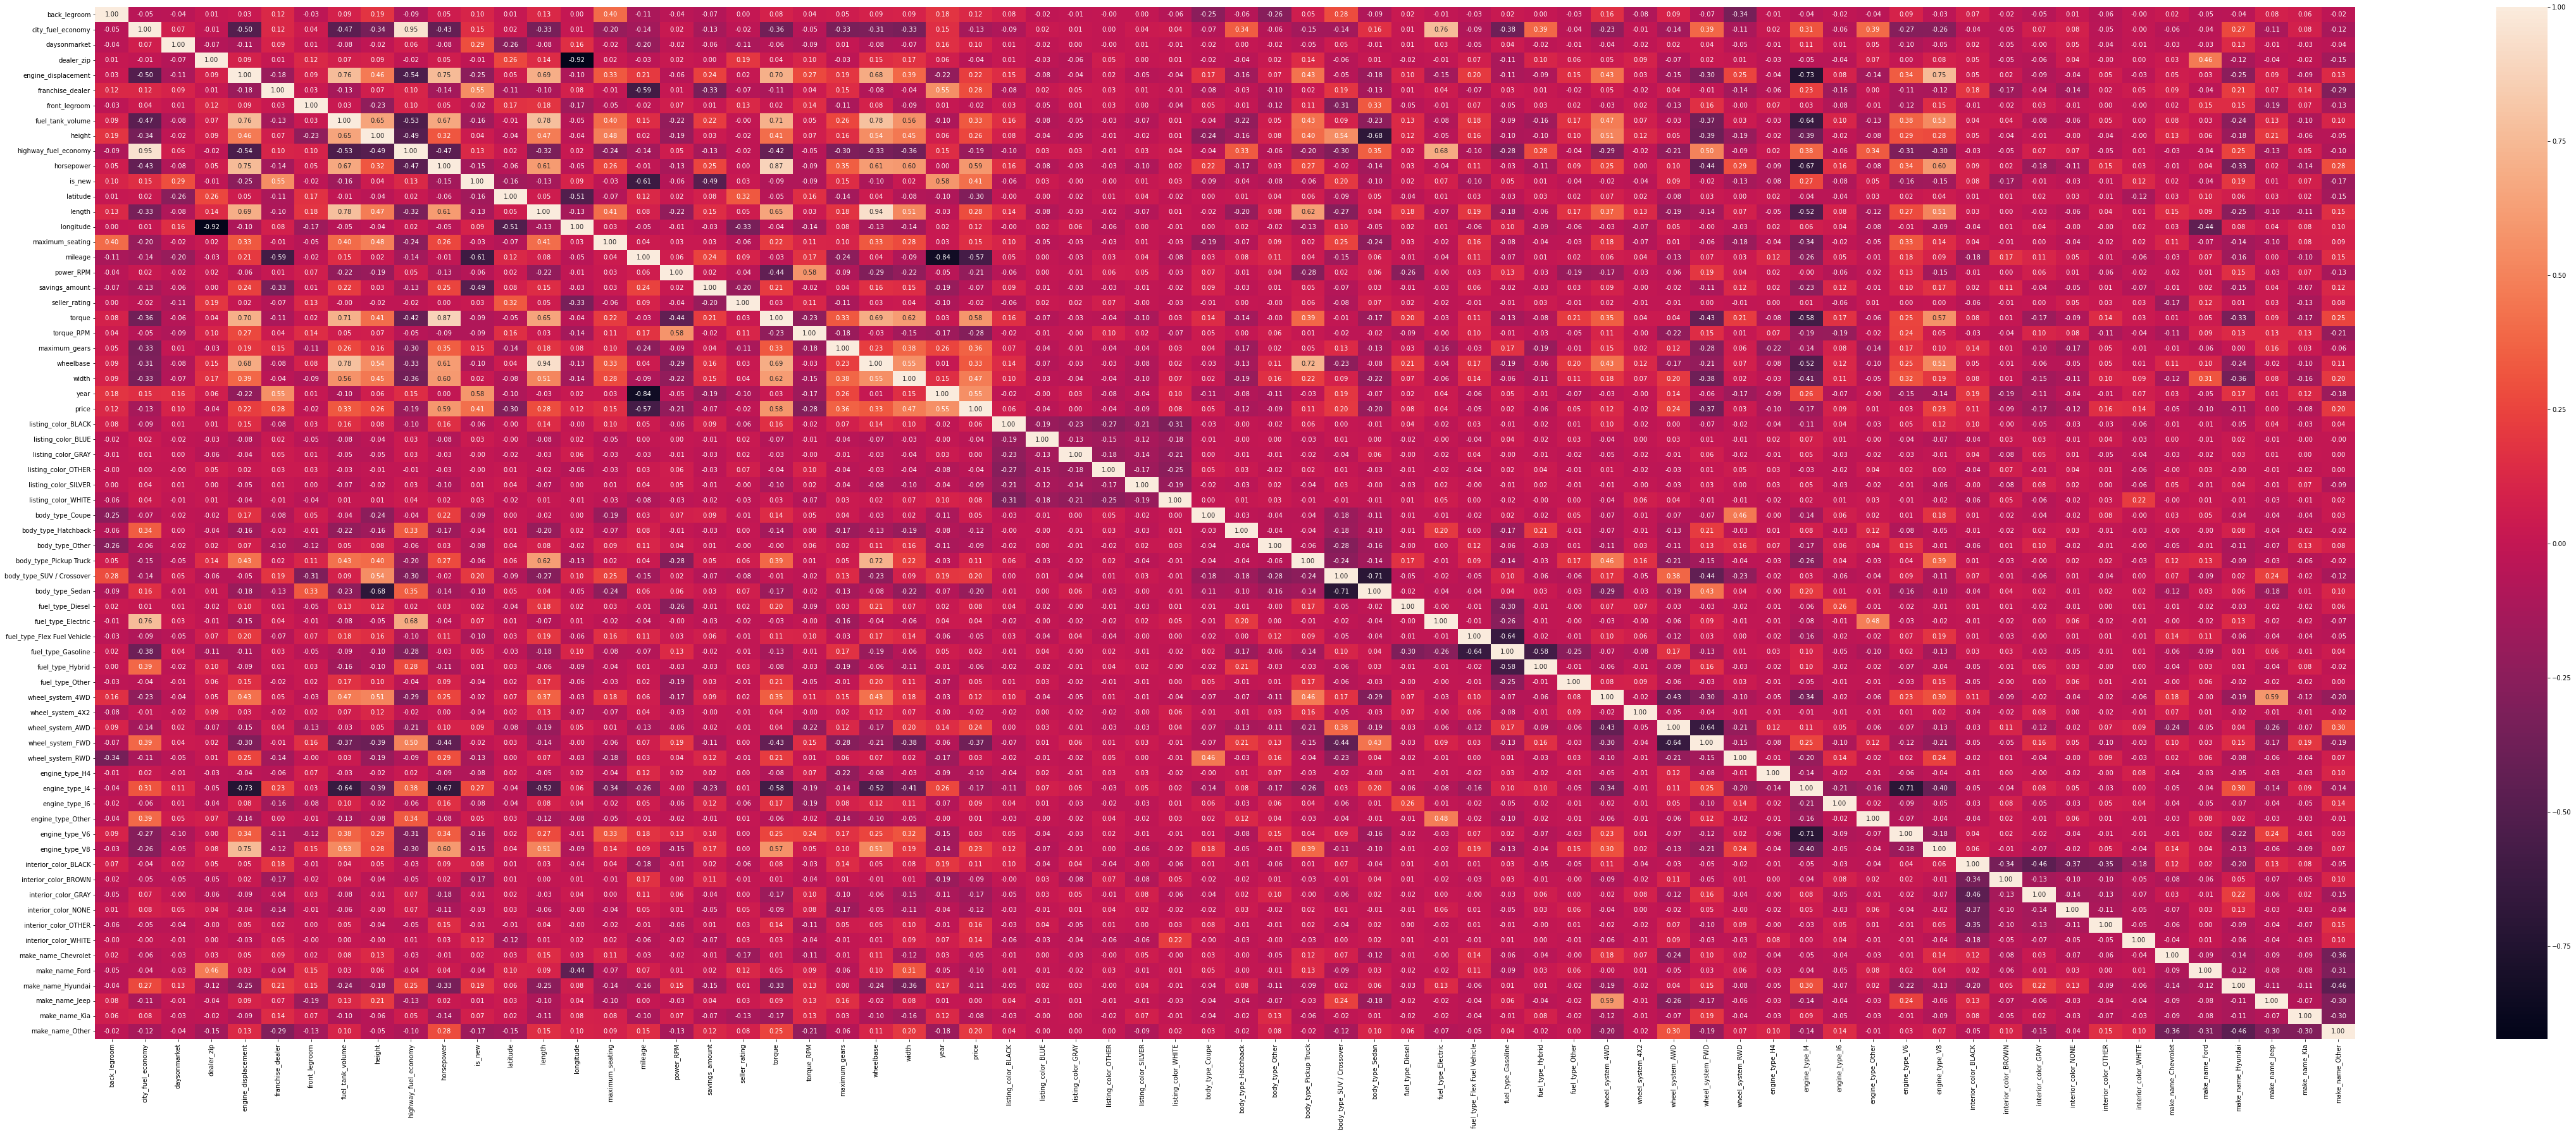

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.select_dtypes(exclude=['object']).corr()
plt.figure(figsize=(80,30))
a = sns.heatmap(corr, annot=True, fmt='.2f')

The matrix above includes all features from our dataframe, including our encoded features, so it can be hard to read. However, when looking at the detail it shows that price has an absolute correlation above 0.5 for `horsepower`, `mileage`, `torque` and `year` suggesting that these features have the most influence on price.

Next we produce a scatter plot matrix for a number of key features:

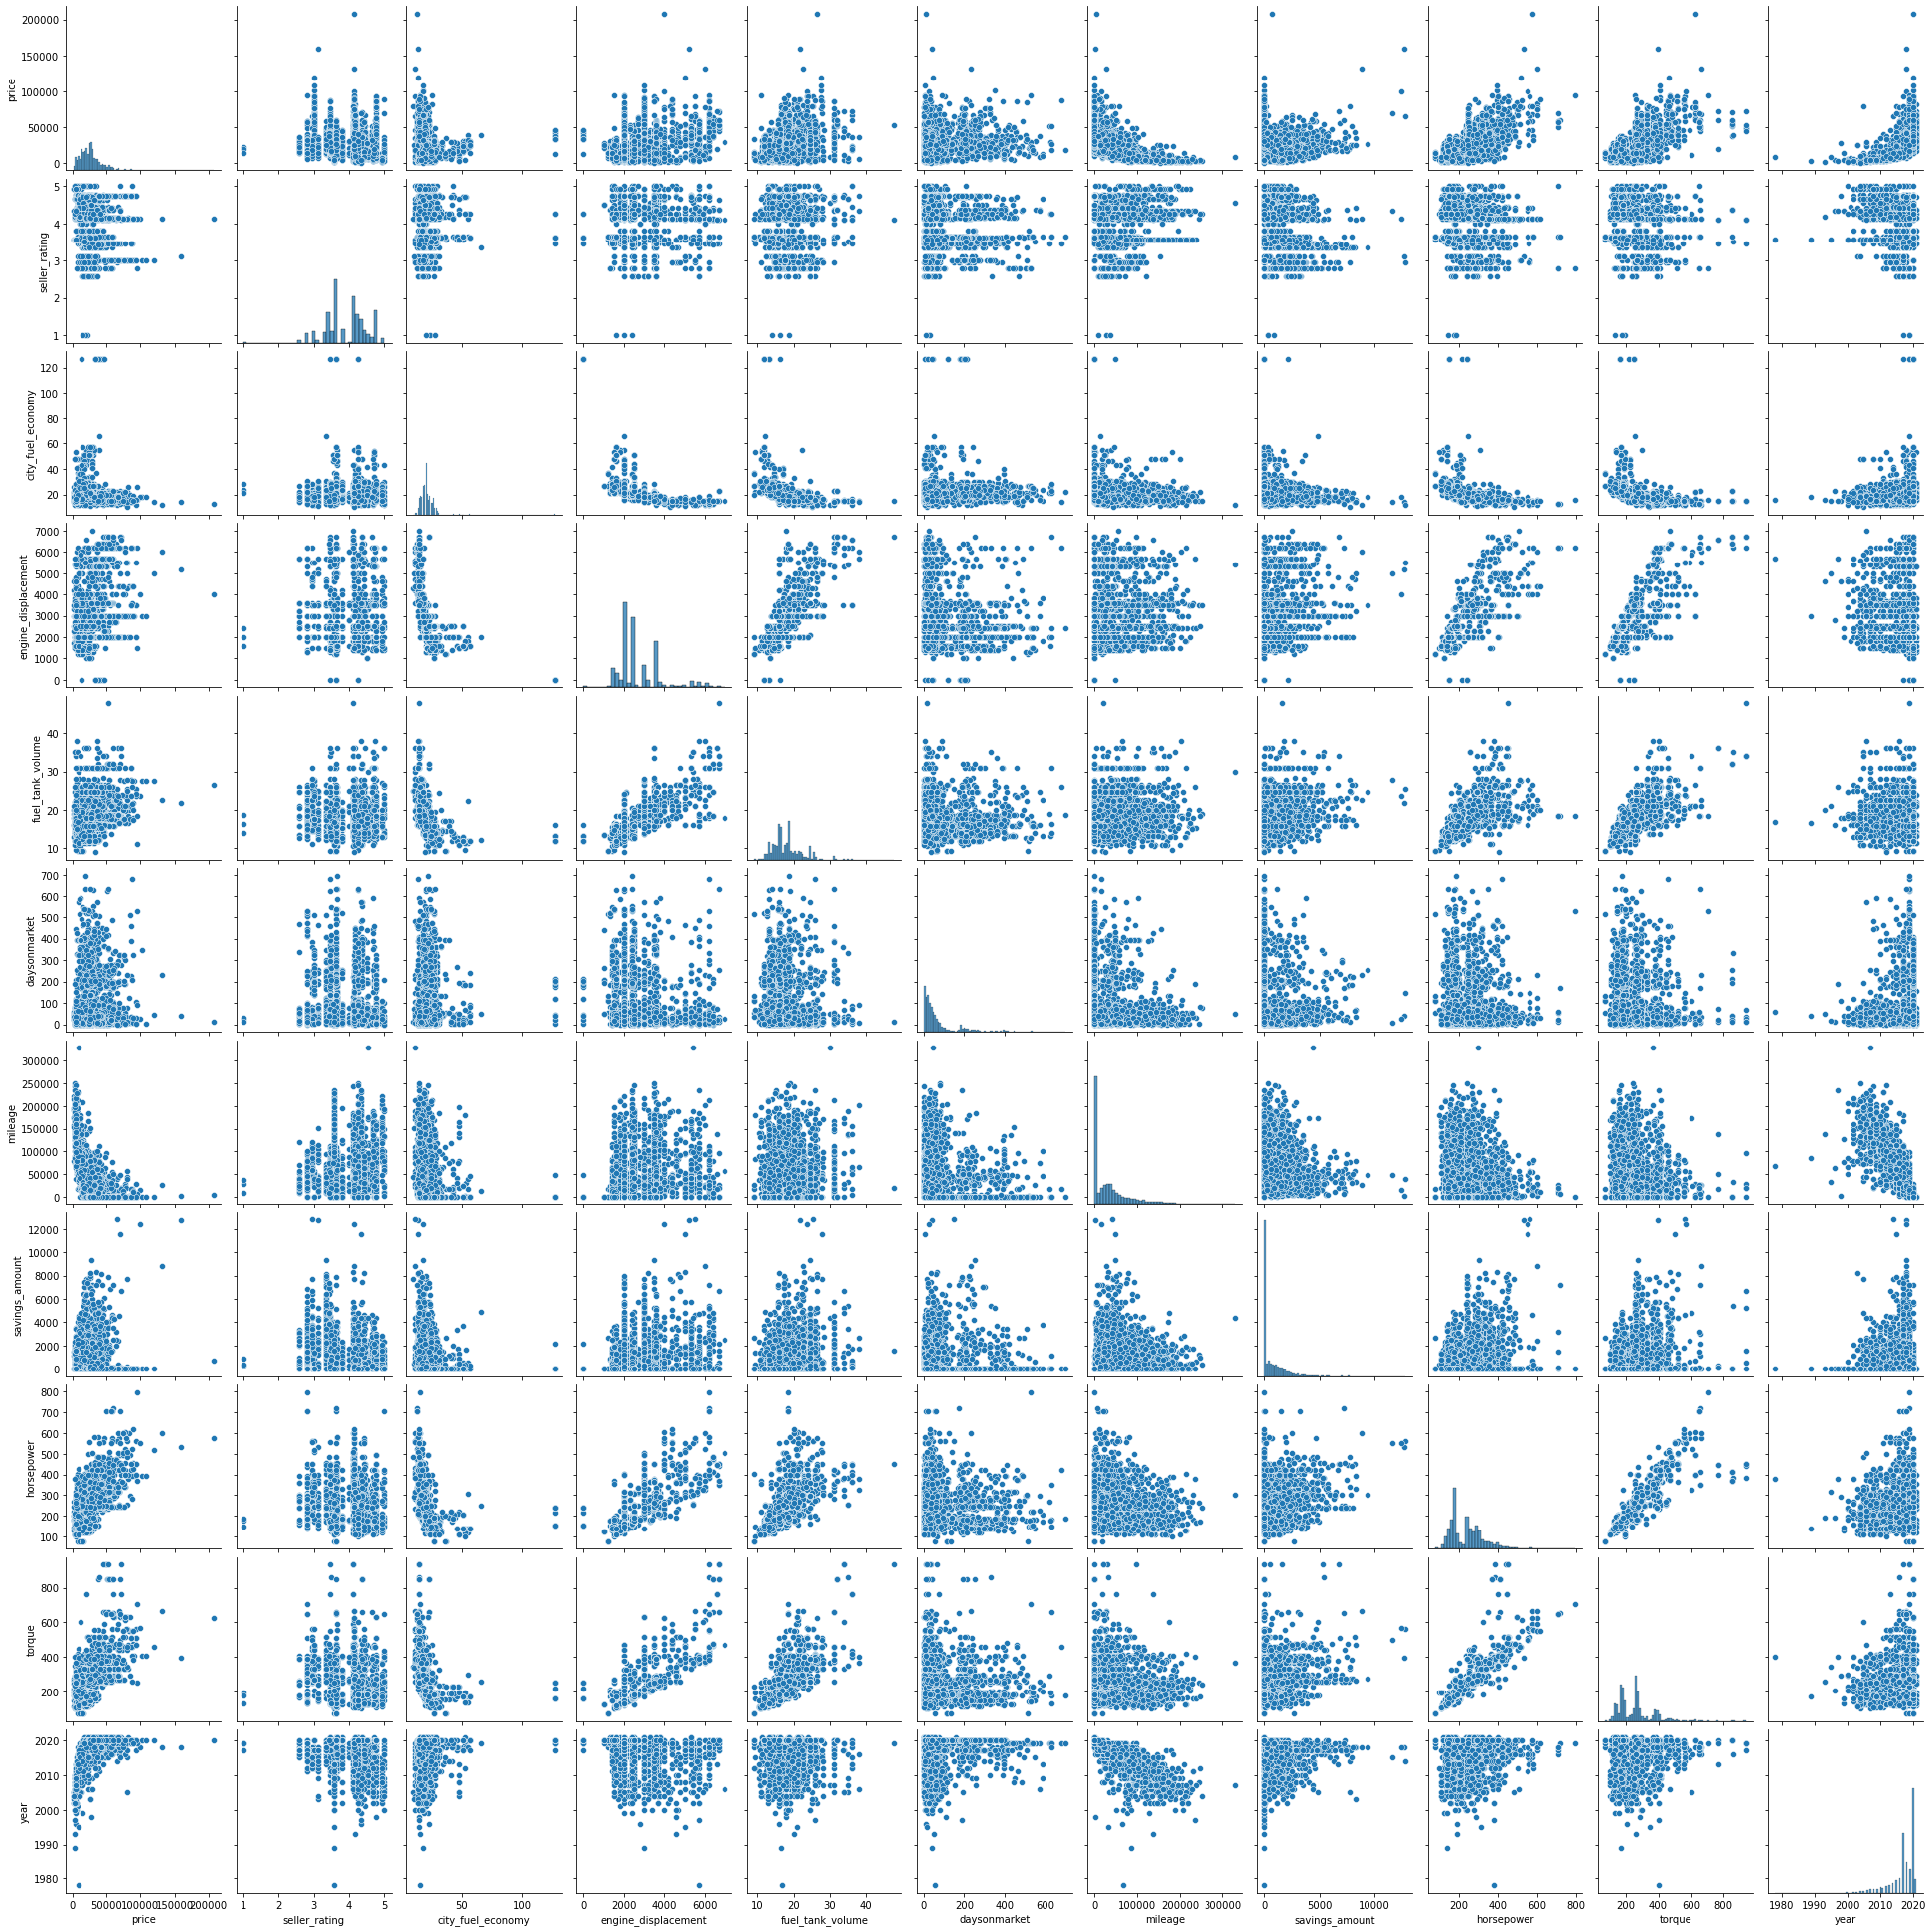

In [46]:
sns.pairplot(df[['price', 'seller_rating','city_fuel_economy','engine_displacement','fuel_tank_volume','daysonmarket','mileage','savings_amount','horsepower','torque','year']])
plt.show();

We see a number of non-linear relationships are present, such as between `mileage` and `price`, and `year` and `price`. There may also be a very loose linear relationship between`price` and `savings_amount`, `horsepower`, and `torque`.

We will look at the influence that `make_name` may have on the price, as this seems to be an intuitive factor in purchasing decisions for a car.

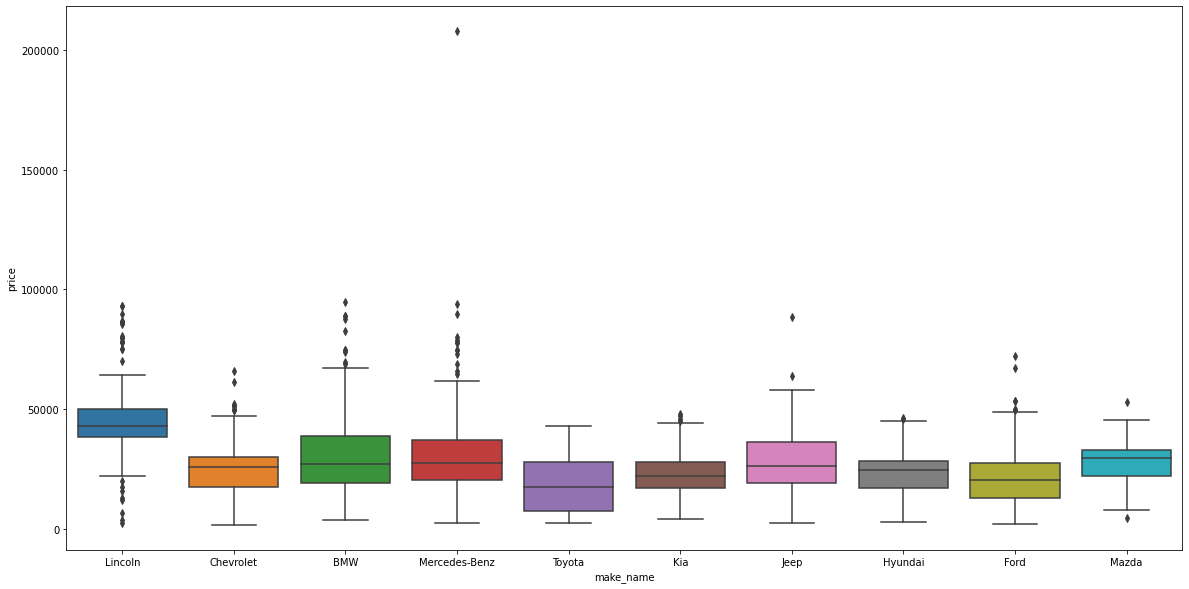

In [47]:
#Getting the most frequent top 10 vehicle companies
listOfMost = df['make_name'].value_counts()[:10].index.tolist();
#Getting the rows only which has selected 10 companies
dfd = df[pd.DataFrame(df.make_name.tolist()).isin(listOfMost).any(1).values];
#Plotting the Graph with sliced data
plt.rcParams['figure.figsize']=(20,10)
ax = sns.boxplot(x="make_name", y="price", data=dfd)

This box plot shows that there is some differences in price for the top 10 makes of vehicle in our data. Lincoln, BMW and Mercedes-Benz have the highest median sales prices. In contrast, Toyota, Kia, and Ford have the lowest median prices.

--- 
## Forecasting

We will start with the model which is used for our final prediction.
The machine learning regression model which we are using for our best prediction is call **XGBoost Regression**. This is available using the `xgboost` package which can be installed using:

```
pip install xgboost
```
or
```
conda install xgboost
```
depending on your machine configuration.

We tried many different machine learning algorithms before settling on XGBoost, including Linear Regression, Random Forest Regression, Support Vector Machine, KNN-Regression and Bagging Regressor. We also used GridSearchCV in tuning hyperparameters for these models. The code showing our initial attempts is shown at the end of this file in the **Appendix**.

**1. Building a machine learning regression model:**
In the code below, the first step is to define our Training and Test dataframes for building the model. In our Training dataframe, we have selectively dropped a number of features which were shown to have low relevancy in Task 2, however there was also some manipulation done in the selection of these features simply using trial and error.

In [48]:
y_train = df['price']
X_train = df.drop(['vin','price','dealer_zip','franchise_dealer','fuel_tank_volume','latitude','longitude','power_RPM','seller_rating','torque_RPM','maximum_gears', 'city_fuel_economy', 'highway_fuel_economy'], axis=1)
X_test = df_test.drop(['vin','dealer_zip','franchise_dealer','fuel_tank_volume','latitude','longitude','power_RPM','seller_rating','torque_RPM','maximum_gears', 'city_fuel_economy', 'highway_fuel_economy'], axis=1)

X_train = X_train.select_dtypes(exclude=['object'])  # removing any text features which remain in the dataframe
X_test = X_test.select_dtypes(exclude=['object'])  # removing text features from the test dataframe

**2. Fit the model and tune hyperparameters:** 
We will now use the `XGBRegressor` algorithm to train and fit our model:

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Firstly we will use GridSearchCV to tune the alpha parameter.

param_grid = {
    'alpha' : [0, 5, 10, 20]  # specifying alpha introduces L1 regularization
}

gs = GridSearchCV(estimator=XGBRegressor(random_state=0),  
                   param_grid=param_grid, scoring = 'neg_root_mean_squared_error', refit=True, cv=10, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_

y_train_pred_XGBoostReg_GS = clf.predict(X_train)
y_test_pred_XGBoostReg_GS = clf.predict(X_test)

print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_XGBoostReg_GS, squared=False):.3f}')

-5266.6040987255465
{'alpha': 0}
RMSE train: 1103.495


We note that the above code suggests that alpha = 0 is the optimal value for this parameter, however we noticed that while this produces the lowest RMSE for our Training data, the Test data fitted with slightly more accuracy when we used alpha=10. As such, we tried different values before settling on the code below:

In [50]:
from xgboost import XGBRegressor

model = XGBRegressor(alpha=10, random_state=0)  

model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

If we try to refine the selection of features for this model, we can use the code below. This has helped to inform our feature selection to some extent but, again, much of our success resulted from trialling different combinations of features until the optimal score was achieved.

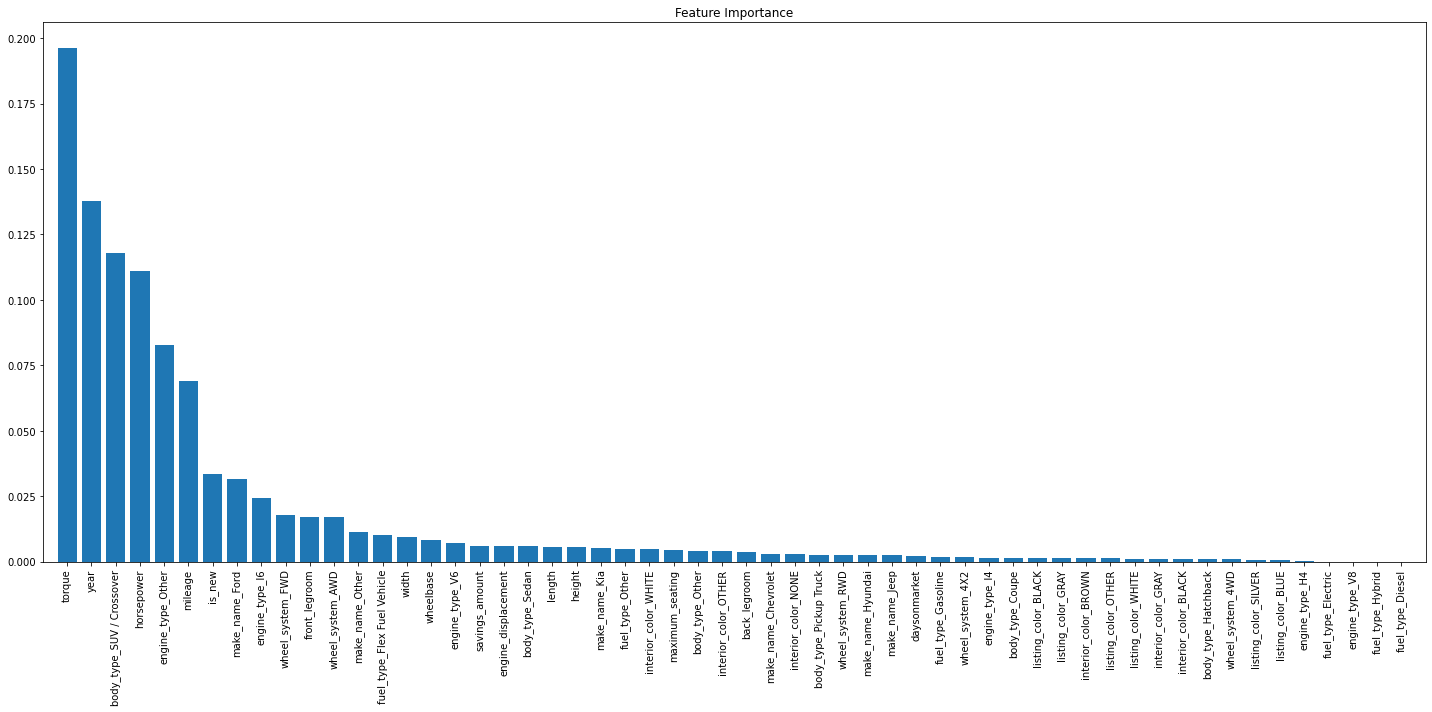

In [51]:
feat_labels = X_train.columns[:]
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

**3. Create predictions using the Test dataset:**
Now exporting our predicted values, we can check the Root Mean Squared Error on our training dataset as well as generate predictions for our Test dataset:

In [52]:
y_train_pred_XGBoost = model.predict(X_train)
y_test_pred_XGBoost = model.predict(X_test)

print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_XGBoost, squared=False):.3f}')

RMSE train: 1113.870


We will then save the prediction output of our model for uploading to the Kaggle competition:

In [53]:
output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_XGBoost})
output.to_csv('final_submission.csv', index=False) 

**4. Kaggle ranking score:**
Our Kaggle ranking score from the above submission was achieved with a Root Mean Squared Error value of 4895.99222:

## Appendix A:

The code below is all commented out, but shows the steps taken in trialling various Machine Learning algorithms before arriving on the code used above.

In [54]:
# Simple Linear Regression:
# from sklearn.linear_model import LinearRegression

# slr = LinearRegression()
# slr.fit(X_train, y_train)

# print(f'Intercept: {slr.intercept_:.3f}')
# print(f'Slope: {slr.coef_[0]:.3f}')

# # obtain fitted predictions for train and test data
# y_train_pred = slr.predict(X_train)
# y_test_pred = slr.predict(X_test)

# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred})

In [55]:
## Linear Regression using a pipeline with StandardScalar and PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.decomposition import KernelPCA

# pipe_slr = make_pipeline(StandardScaler(),
#                         PCA(),
#                         LinearRegression())

# param_grid = {
#     "pca__n_components": [2, 5, 10, 15, 20, 30, 'mle']
# }

# gs = GridSearchCV(estimator=pipe_slr,
#                    param_grid=param_grid, scoring = 'neg_root_mean_squared_error', refit=True, cv=10, n_jobs=-1)

# gs.fit(X_train, y_train)

# print(gs.best_score_)
# print(gs.best_params_)

# clf = gs.best_estimator_

# y_train_pred_GS_LinReg = clf.predict(X_train)
# y_test_pred_GS_LinReg = clf.predict(X_test)
# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_GS_LinReg, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_GS_LinReg})


In [56]:
##Regularized Regression -> Lasso
# from sklearn.linear_model import Lasso

# LassoModel = Lasso(alpha=1.0)
# LassoModel.fit(X_train, y_train)
# y_train_pred_Lasso = LassoModel.predict(X_train)
# y_test_pred_Lasso = LassoModel.predict(X_test)
# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_Lasso, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_Lasso})

In [57]:
##Regularized Regression -> Ridge
# from sklearn.linear_model import Ridge

# RidgeModel = Ridge(alpha=1.0)
# RidgeModel.fit(X_train, y_train)
# y_train_pred_Ridge = RidgeModel.predict(X_train)
# y_test_pred_Ridge = RidgeModel.predict(X_test)
# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_Ridge, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_Ridge})

In [58]:
##Regularized Regression -> Elastic Net
# from sklearn.linear_model import ElasticNet

# ElasticNetModel = ElasticNet(alpha=1.0)
# ElasticNetModel.fit(X_train, y_train)
# y_train_pred_ElasticNet = ElasticNetModel.predict(X_train)
# y_test_pred_ElasticNet = ElasticNetModel.predict(X_test)
# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_ElasticNet, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_ElasticNet})

In [59]:
##AdaBoost Regression
# from sklearn.ensemble import AdaBoostRegressor
# AdaBoostRegressorModel = AdaBoostRegressor(random_state=0, n_estimators=100)
# AdaBoostRegressorModel.fit(X_train, y_train)
# y_train_pred_AdaBoost = AdaBoostRegressorModel.predict(X_train)
# y_test_pred_AdaBoost = AdaBoostRegressorModel.predict(X_test)
# print(f'RMSE train: {mean_squared_error(y_train, y_train_pred_AdaBoost, squared=False):.3f}')
# output = pd.DataFrame({'vin': df_test.vin, 'price': y_test_pred_AdaBoost})